In [5]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import datetime
# auto reolad zewnetrznych skryptow bez resetowania notebooka
import sys
sys.path.append('..')
import models
from utils.modeling_utils import SequenceGeneratorCV

%reload_ext autoreload
%autoreload 2

DEVICE = "cpu"

# Data prep

Ładujemy cały zbiór danych

In [40]:
df = pd.read_csv('../../data/csv/six_cities.csv')
df['dt'] = pd.to_datetime(df['dt'])

# df = df[df['city'].isin(['Warszawa'])]
# df = df.reset_index(drop=True)

Tutaj kwestia na jakich parametrach był model uczony i z jakimi zmiennymi. Dobrze by było jakby te informacja gdzieś zostały przechowane. *NORMALIZE_FEATURES* to po prostu lista zmiennych wymagających poprawy rozkładu. Moją one mocno lewo/prawo skośne rozkłady i jeśli dodamy taką zmienną do *numeric_features* to uzywany jest na niech power transformer sprowadzający do rozkładu normalnego.

Takie wązne do ustawienia to:
- dlugosc sekwencji wejsciowej i wyjsciowej
- numeric, categorical i output features

Do wywolywania samej predykcji nie ma znaczenia reszta parametrów

In [53]:
# na podstawie 96 godzin predykcja na dwa nastepne dni
input_width, output_width = int(7*24), 48

# one moga zostac bez problemu jako stala czy cos, maja rozklady bardzo nienormalne
normalize_features = ['humidity', 'clouds.all', 'rain.1h', 'snow.1h', 'co', 'no', 'no2', 'so2', 'pm2_5', 'pm10', 'nh3']

# zmienne numeryczne ktore chcemy wykorzystac w modelu
numeric_features = ['day_sin',	'day_cos', 'week_sin', 'week_cos', 'month_sin','month_cos', 'temp', 'pressure', 'humidity', 'wind.x', 'wind.y', 'clouds.all', 'rain.1h', 'snow.1h', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']

# zmienne kategoryczne ktore chcemy wykorzystac w modelu
categorical_features = ['state']

# zmienne ktorych chcemy robic predykcje
output_columns = ['co', 'no', 'no2', 'o3', 'so2',	'pm2_5', 'pm10', 'nh3']

seq_gen = SequenceGeneratorCV(
    numeric_features = numeric_features, 
    categorical_features = categorical_features,
    output_features = output_columns,
    normalize_features = normalize_features,
    input_width = input_width, output_width = output_width,
    device = DEVICE 
)
seq_gen.init_preprocessor(df)

## Załadowanie jednego z modeli i odpowiadajacego preprocessora

In [63]:
from pickle import load

learned_params = {}

model = models.ARmodel(seq_gen, **learned_params)
model.load_state_dict(torch.load(f'../trained_models/ar_seq2seq/model.pkl'))
preprocessor = load(open(f'../trained_models/ar_seq2seq/preprocesor.pkl', 'rb'))

# Predykcje

Koncepcyjnie: 

1. wybieramy miasto dla, którego robimy predykcje
2. Na podstawie wcześniej opisanych parametrów (dlugosc sekwencji, zmienne itd) tworzymy dataframe
3. Korzystamy z preprocessingu, aby przeprowadzic standaryzacje danych itd, usuwamy pierwsza kolumne (nazwa miasta)
3. Wywolujemy model do predykcji
4. Dla otrzymanych predykcji stosujemy inverse transformacje, aby sprowadzić spowrotem na rzeczywiste zakresy wartości dla wizualizacji
5. Możemy wyświetlić nowe dane w jakimś kontekście

In [73]:
df_wwa = df[df.city == 'Warszawa']
# ostatnie zarejestrowane 96h z warszawy
df_pred = df_wwa.iloc[-input_width: , :]
# preprocessing
#df_pred = preprocessor.transform(df_pred).iloc[:, 1:]
# pca wymaga innego formatu
df_pred = preprocessor.transform(df_pred)
df_pred.head()

,city,humidity,clouds.all,rain.1h,snow.1h,co,no,no2,so2,pm2_5,...,pressure,wind.x,wind.y,o3,state_Lower Silesian Voivodeship,state_Lubusz Voivodeship,state_Masovian Voivodeship,state_Podlaskie Voivodeship,state_Pomeranian Voivodeship,state_Silesian Voivodeship
9110,Warszawa,-1.146994,-1.702123,-0.251995,-0.156001,0.702611,1.989351,0.741942,1.264196,0.542866,...,0.403065,-0.303160,0.774032,-0.392588,0.0,0.0,1.0,0.0,0.0,0.0
9111,Warszawa,-1.515024,-1.702123,-0.251995,-0.156001,0.321212,1.900844,0.457236,1.088173,0.322269,...,0.403065,-0.682188,1.326351,-0.129157,0.0,0.0,1.0,0.0,0.0,0.0
9112,Warszawa,-1.668463,-1.702123,-0.251995,-0.156001,0.010615,1.715930,0.199039,0.907120,0.181583,...,0.290804,-0.965540,1.739250,0.121646,0.0,0.0,1.0,0.0,0.0,0.0
9113,Warszawa,-1.801815,-1.702123,-0.251995,-0.156001,-0.604453,0.478585,-0.699251,0.128137,-0.485837,...,0.290804,-1.059377,1.875989,1.677329,0.0,0.0,1.0,0.0,0.0,0.0
9114,Warszawa,-1.826097,-1.702123,-0.251995,-0.156001,-0.711973,0.139160,-0.927025,-0.141917,-0.488601,...,0.290804,-1.438406,2.428308,1.928132,0.0,0.0,1.0,0.0,0.0,0.0


Każdy model powinien mieć funkcje pomocnicza do robienia predykcji,  ustawiamy tam model w tryb evaluacji i obsluge przygotowania formatu, normalnie model oczekuje formatu **(batch, length, features)**. My natomiast dajemy tylko **(length, features)** temu tam wykonuje unsequeeze(0), aby dodac wymiar z przodu.

In [75]:
# predykcja
y_prediction = model.make_predictions(df_pred.drop(columns='city'))
y_prediction.shape

(48, 8)

Utility funkcja do rescalowania zmiennej

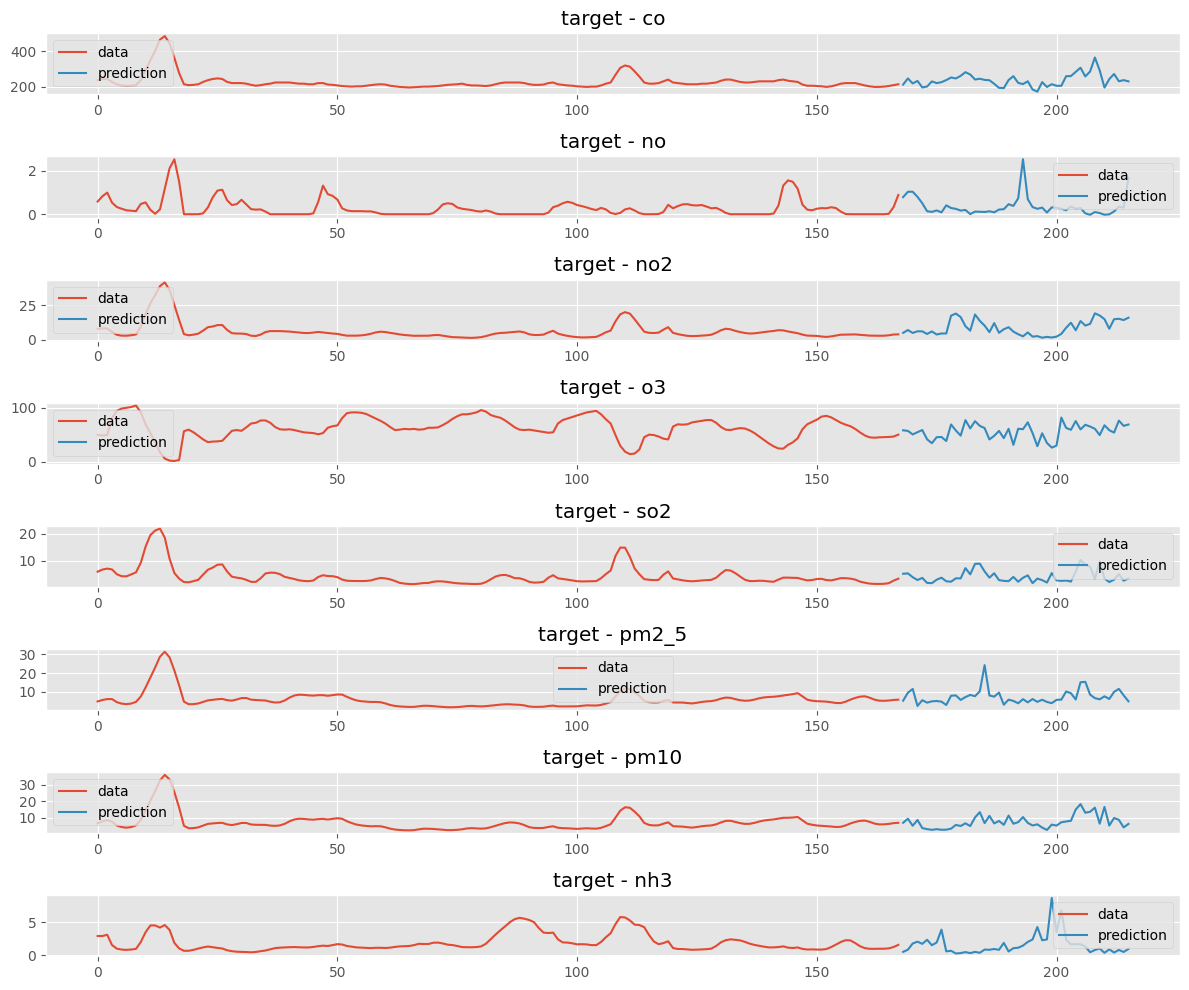

In [77]:
from utils import predictions

y_prediction_rescaled = predictions.rescale_predictions(
    y_prediction, 
    preprocessor, 
    output_width, 
    output_columns
)

# wyrysowanie ostatniego tygodnia
display_df = df.iloc[-24*7:, :]
t = np.arange(0, len(display_df) + output_width)

fig, ax = plt.subplots(len(output_columns), 1, figsize=(12, 10))
for i in range(len(seq_gen.output_columns_idx)):
    if not hasattr(ax, '__len__'):
        ax = [ax]
    ax[i].plot(t[:len(display_df)], display_df[output_columns[i]])
    ax[i].plot(t[len(display_df):], y_prediction_rescaled[:, i])
    ax[i].legend(['data', 'prediction'])
    ax[i].set_title(f'target - {output_columns[i]}')

fig.tight_layout()

In [91]:
df_wwa = df[df.city == 'Warszawa']
# ostatnie zarejestrowane 96h z warszawy
df_pred = df_wwa.iloc[-input_width-output_width:-output_width , :]
# preprocessing
#df_pred = preprocessor.transform(df_pred).iloc[:, 1:]
# pca wymaga innego formatu
df_pred = preprocessor.transform(df_pred)

In [90]:
# predykcja
y_prediction = model.make_predictions(df_pred.drop(columns='city'))
y_prediction_rescaled = predictions.rescale_predictions(y_prediction, preprocessor, output_width, output_columns)

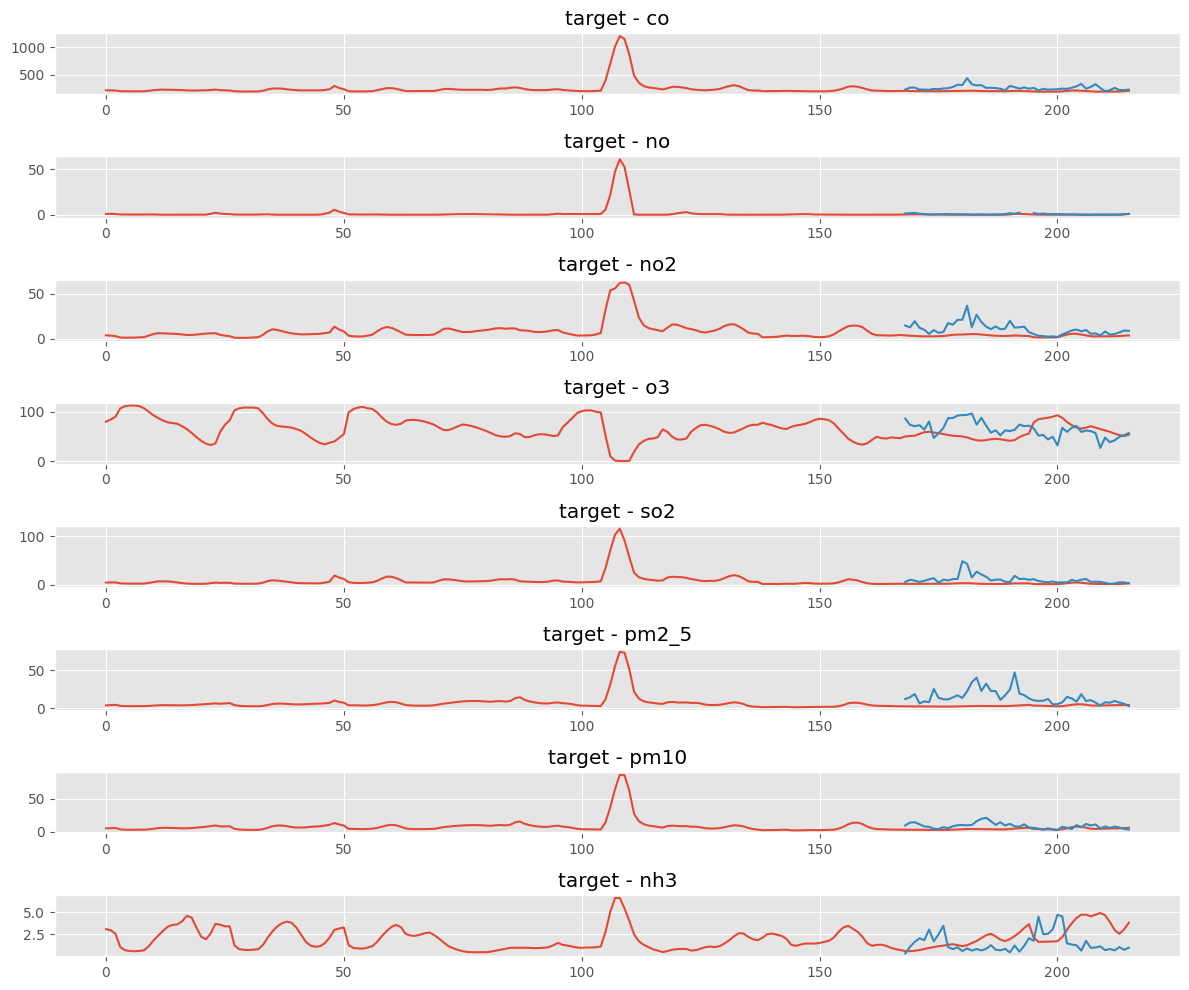

In [103]:
# 
t = np.arange(0, len(df_wwa.iloc[-input_width-output_width: , :]))

fig, ax = plt.subplots(len(output_columns), 1, figsize=(12, 10))
for i in range(len(seq_gen.output_columns_idx)):
    ax[i].plot(t, df_wwa.iloc[-input_width-output_width: , :][output_columns[i]])
    ax[i].plot(t[-output_width:], y_prediction_rescaled[:, i])

    ax[i].set_title(f'target - {output_columns[i]}')

fig.tight_layout()